# Using News to Predict Stock Movements
**Yicheng Wang**  
**FRE7773 Machine Learning Project**  
**Fall 2018**

# Abstract
Using machine learning techniques - LSTM model, I will predict the direction of next market-residualized returns from news data about news articles/alerts published about assets, such as article details, sentiment, and other commentary. Then, I will use this direction to trade by building a long short portfolio that long the predicted positive return stocks and short the predicted negative return stocks rolling in the test period. 

**Note: this project uses data that can only be used internally in Kaggle, so it cannot run locally.** 

Source: https://www.kaggle.com/c/two-sigma-financial-news

# Data

In [1]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [4]:
import numpy as np
import pandas as pd
import talib
import time
from datetime import datetime

import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
%matplotlib inline

In [6]:
# DataFrames contain all market and news data from February 2007 to December 2016
(market_train_df, news_train_df) = env.get_training_data()

In [7]:
market_train_df['date_market'] = market_train_df.time.dt.date  # time to date
news_train_df['date_news'] = news_train_df.time.dt.date  # time to date

In [8]:
sp500 = pd.read_csv("../input/sp500/data.csv", index_col=0, parse_dates=True)

# Exploratory Data Analysis

## Market Data

### Technical indicators

In [9]:
# momentum indicators: MACD, RSI, MOM
market_train_df['macd'] = market_train_df.groupby(
    ['assetCode']).apply(lambda x: talib.MACD(x['close'])[0]
                        ).reset_index().set_index('level_1')[0]
market_train_df['rsi'] = market_train_df.groupby(
    ['assetCode']).apply(lambda x: talib.RSI(x['close'])
                        ).reset_index().set_index('level_1')[0]
market_train_df['mom'] = market_train_df.groupby(
    ['assetCode']).apply(lambda x: talib.MOM(x['close'])
                        ).reset_index().set_index('level_1')[0]
# volume indicator: OBV
market_train_df['obv'] = market_train_df.groupby(
    ['assetCode']).apply(lambda x: talib.OBV(x['close'], x['volume'])
                        ).reset_index().set_index('level_1')[0]

In [10]:
# standard deviations, sum of volumes
market_train_df['close_std10'] = market_train_df.groupby(
    ['assetName'])['close'].rolling(10).std().reset_index().set_index('level_1')['close']
market_train_df['volume_sum10'] = market_train_df.groupby(
    ['assetName'])['volume'].rolling(10).sum().reset_index().set_index('level_1')['volume']

In [11]:
print('{} samples, {} assets, and {} features in the training news dataset.'.format(
    market_train_df.shape[0], len(market_train_df['assetName'].unique()), 
    market_train_df.shape[1]))

4072956 samples, 3511 assets, and 23 features in the training news dataset.


In [12]:
market_train_df.columns

Index(['time', 'assetCode', 'assetName', 'volume', 'close', 'open',
       'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10', 'universe', 'date_market', 'macd', 'rsi',
       'mom', 'obv', 'close_std10', 'volume_sum10'],
      dtype='object')

### Visualization

In [ ]:
data = []
for stk in np.random.choice(market_train_df['assetName'].unique(), 10):
    stk_df = market_train_df[(market_train_df['assetName'] == stk)]

    data.append(go.Scatter(
                        x = stk_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
                        y = stk_df['close'].values,
                        name = stk)
               )
    
layout = go.Layout(dict(title = "10 random closing prices",
                        xaxis = dict(title = 'Date'),
                        yaxis = dict(title = 'Price'),
                       ),
                   legend=dict(orientation="h")
                  )

py.iplot(dict(data=data, layout=layout))

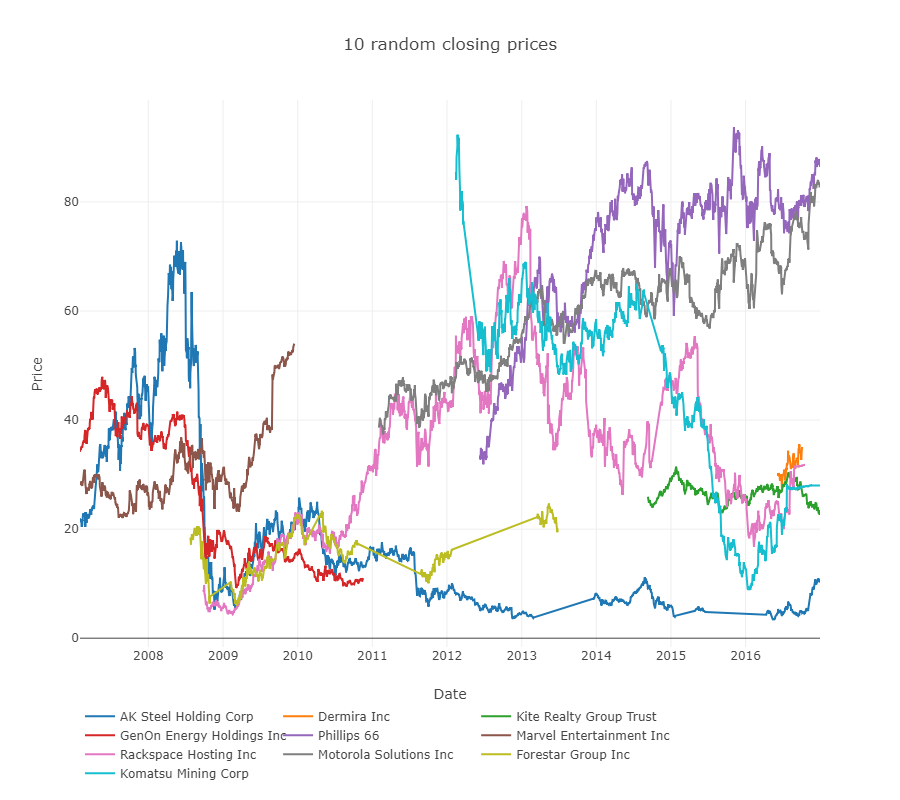

In [2]:
from IPython.display import Image
Image(filename = "newplot3.png", width=800, height=800)

In [ ]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['close'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['close'].values,
        name = f'{i} quantile'
    ))
    
layout = go.Layout(dict(title = "Quantiles of stocks",
                    xaxis = dict(title = 'Date'),
                    yaxis = dict(title = 'Stock Price'),
                       ),
                   legend=dict(orientation="h")
                  )

py.iplot(dict(data=data, layout=layout))

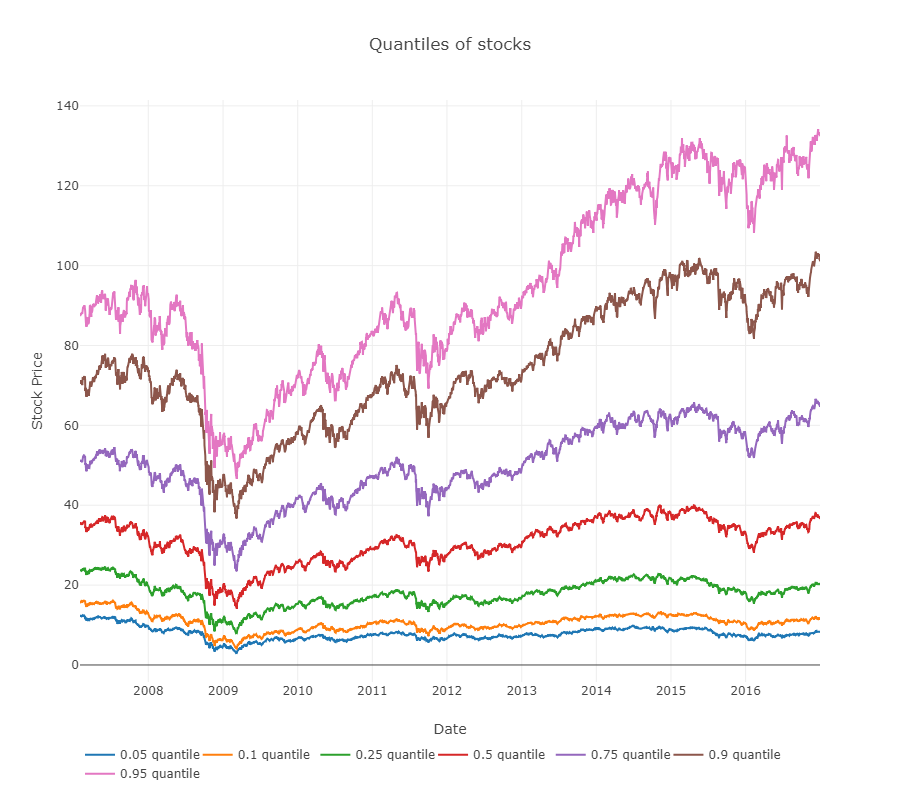

In [30]:
Image(filename = "newplot2.png", width=800, height=800)

In [ ]:
data = []
for stk in np.random.choice(market_train_df['assetName'].unique(), 10):
    stk_df = market_train_df[(market_train_df['assetName'] == stk)]

    data.append(go.Bar(
                        x = stk_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
                        y = stk_df['volume'].values,
                        name = stk)
               )
    
layout = go.Layout(dict(title = "10 random stocks volume",
                        xaxis = dict(title = 'Date'),
                        yaxis = dict(title = 'Volume'),
                       ),
                   legend=dict(orientation="h")
                  )

py.iplot(dict(data=data, layout=layout))
del data

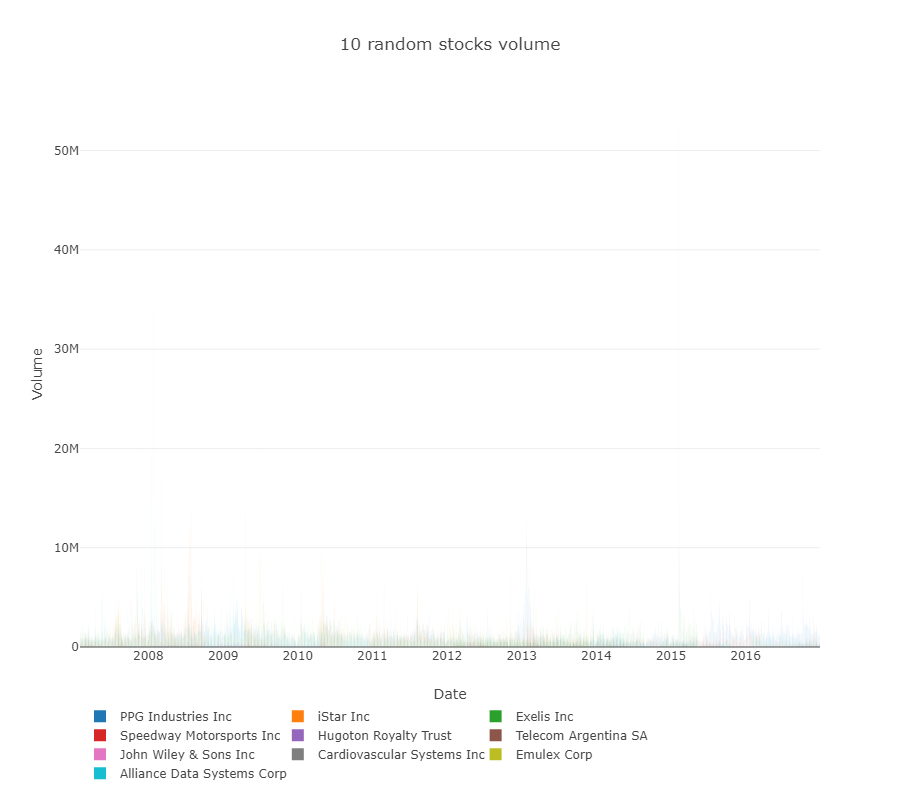

In [29]:
Image(filename = "newplot1.png", width=800, height=800)

We get some extremely high stock activities in 2008-2009 and 2015.

In [16]:
market_train_df.describe()

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,macd,rsi,mom,obv,close_std10,volume_sum10
count,4.072956e+06,4.072956e+06,4.072956e+06,4.072956e+06,4.072956e+06,4.056976e+06,4.056968e+06,4.072956e+06,4.072956e+06,3.979946e+06,3.979902e+06,4.072956e+06,4.072956e+06,3.953894e+06,4.021206e+06,4.035737e+06,4.072956e+06,4.041732e+06,4.041732e+06
mean,2.665312e+06,3.971241e+01,3.971233e+01,5.473026e-04,9.569113e-03,1.738580e-04,9.309293e-03,5.232021e-03,1.423685e-02,1.638857e-03,1.481702e-02,1.405528e-02,5.949365e-01,5.142915e-02,5.136263e+01,7.540516e-02,1.831758e+07,1.146128e+00,2.674124e+07
std,7.687606e+06,4.228822e+01,4.261116e+01,3.697774e-02,7.084388e+00,3.270305e-02,6.968866e+00,8.872484e-02,7.123552e+00,7.517820e-02,7.285742e+00,7.242467e+00,4.909044e-01,1.605351e+00,1.235566e+01,4.602277e+00,2.356040e+08,2.454329e+00,7.034922e+07
min,0.000000e+00,7.000000e-02,1.000000e-02,-9.776464e-01,-9.998881e-01,-1.235622e+00,-6.158463e+02,-9.774034e-01,-9.998904e-01,-3.343277e+00,-1.375045e+03,-1.375045e+03,0.000000e+00,-2.024574e+02,0.000000e+00,-7.650900e+02,-5.045673e+09,0.000000e+00,1.020000e+04
25%,4.657968e+05,1.725000e+01,1.725000e+01,-1.089241e-02,-1.108987e-02,-8.569246e-03,-1.002114e-02,-3.339148e-02,-3.337574e-02,-2.927584e-02,-2.962645e-02,-2.970509e-02,0.000000e+00,-3.365504e-01,4.284944e+01,-9.600000e-01,-1.161086e+07,3.620313e-01,5.246970e+06
50%,9.821000e+05,3.030000e+01,3.029000e+01,3.373819e-04,3.824092e-04,-1.236127e-04,-3.356938e-06,5.160339e-03,5.165128e-03,8.329261e-04,1.126206e-03,1.044642e-03,1.000000e+00,6.533701e-02,5.155021e+01,1.100000e-01,4.953400e+06,6.570380e-01,1.056597e+07
75%,2.403165e+06,4.986000e+01,4.985000e+01,1.165695e-02,1.183612e-02,8.397528e-03,1.002712e-02,4.297606e-02,4.298507e-02,3.059022e-02,3.171535e-02,3.152750e-02,1.000000e+00,4.953208e-01,6.000697e+01,1.230000e+00,3.460453e+07,1.181694e+00,2.496402e+07
max,1.226791e+09,1.578130e+03,9.998990e+03,4.559245e+01,9.209000e+03,4.512244e+01,8.989207e+03,4.667181e+01,9.382000e+03,4.624971e+01,9.761338e+03,9.761338e+03,1.000000e+00,8.995450e+01,1.000000e+02,3.747900e+02,1.004752e+10,3.909133e+02,6.663201e+09


## News Data

In [17]:
print('{} samples, {} assets, and {} features in the training news dataset.'.format(
    news_train_df.shape[0], len(news_train_df['assetName'].unique()), news_train_df.shape[1]))

9328750 samples, 8902 assets, and 36 features in the training news dataset.


In [18]:
news_train_df.drop(['sourceTimestamp', 'firstCreated', 'sourceId',
                    'provider', 'takeSequence', 'subjects',
                   'audiences'], axis=1, inplace=True)

In [19]:
# transform to asset codes to only first one
news_train_df['assetCodes'] = news_train_df['assetCodes'].map(lambda x: list(eval(x))[0])

### Headline
headline(object) - the item's headline  
headlineTag(object) - the Thomson Reuters headline tag for the news item  

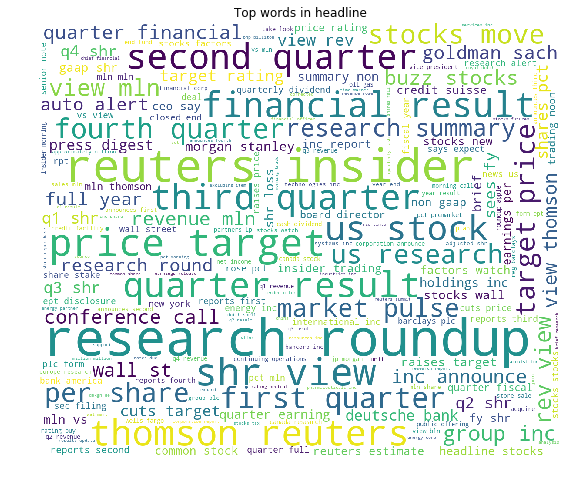

In [20]:
text = ' '.join(np.random.choice(news_train_df['headline'].str.lower().values, 1000000))
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()
del text, wordcloud

Top occurring words are 'reuters' (since news data are from thomson reuters), 'research', 'roundup', 'financial', 'result', 'quarter', 'target', 'view' ... showing these news are reporting facts and giving views about the company. 

In [21]:
# length of headline: integer
news_train_df['headline_length'] = np.vectorize(len)(news_train_df['headline'])

(array([1.046720e+05, 2.116444e+06, 4.071293e+06, 1.672903e+06,
        8.783550e+05, 3.717980e+05, 7.174800e+04, 2.569700e+04,
        1.461800e+04, 1.222000e+03]),
 array([  0. ,  27.2,  54.4,  81.6, 108.8, 136. , 163.2, 190.4, 217.6,
        244.8, 272. ]),
 <a list of 10 Patch objects>)

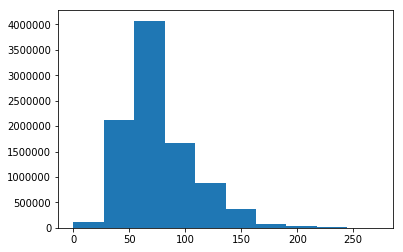

In [22]:
plt.hist(news_train_df['headline_length'])

Most headlines have length about 50-100 words.

In [23]:
# headline tag: string -> categorical
tag_label = {k: v for v, k in enumerate(news_train_df['headlineTag'].unique())}
news_train_df['headlineTag'] = news_train_df['headlineTag'].map(tag_label)
del tag_label

In [24]:
# if there is headline tag: boolean
news_train_df['headlineTag_bool'] = (news_train_df['headlineTag'] > 0)

In [25]:
def plot_class_hist(prob_list):
    ax = prob_list.plot('bar')
    ax.set_title(prob_list.name)
    ax.set_ylabel('proportion')
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),3)), (p.get_x() + 0.2, p.get_height() * 1.01))
    plt.show()

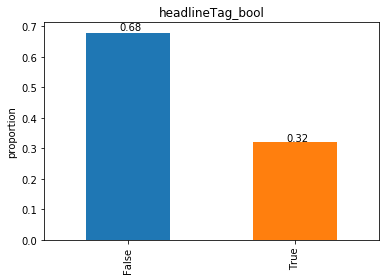

In [26]:
headlineTag_bool = news_train_df['headlineTag_bool'].value_counts() / len(news_train_df)
plot_class_hist(headlineTag_bool)
del headlineTag_bool

A larger proportion of the news don't have headline tags.

### Urgency
urgency(int8) - differentiates story types (1: alert, 3: article)  
  
firstMentionSentence(int16) - the first sentence, starting with the headline, in which the scored asset is mentioned.  
1: headline  
2: first sentence of the story body  
3: second sentence of the body, etc  
0: the asset being scored was not found in the news item's headline or body text. As a result, the entire news item's text (headline + body) will be used to determine the sentiment score.  
  
relevance(float32) - a decimal number indicating the relevance of the news item to the asset. It ranges from 0 to 1. If the asset is mentioned in the headline, the relevance is set to 1. When the item is an alert (urgency == 1), relevance should be gauged by firstMentionSentence instead.

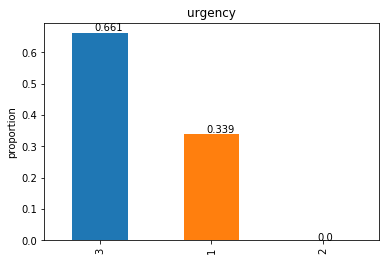

In [27]:
# 3 levels of news urgency: categorical
urgency = news_train_df['urgency'].value_counts() / len(news_train_df)
plot_class_hist(urgency)
del urgency

34% of news are alerts.

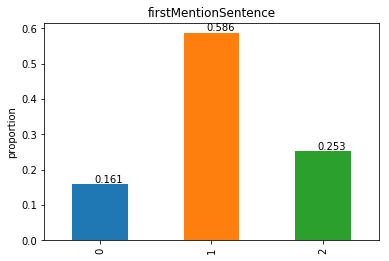

In [28]:
# position of first mentioning of company name: int
firstMentionSentence = pd.Series([
    len(news_train_df[news_train_df['firstMentionSentence'] ==0]) / len(news_train_df),
    len(news_train_df[news_train_df['firstMentionSentence'] ==1]) / len(news_train_df),
    len(news_train_df[news_train_df['firstMentionSentence'] >=2]) / len(news_train_df)],
    name = 'firstMentionSentence')
plot_class_hist(firstMentionSentence)
del firstMentionSentence

16% of news have company name in the headline, 59% are in the first sentence, while the rest are in the following sentences.

(array([1646521.,  775002.,  389218.,  311429., 6206580.]),
 array([0.0012584 , 0.20100673, 0.40075505, 0.6005034 , 0.80025166,
        1.        ], dtype=float32),
 <a list of 5 Patch objects>)

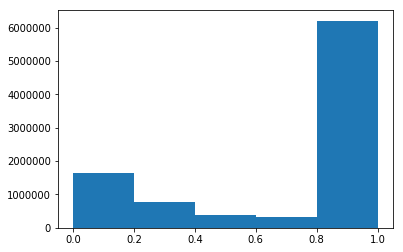

In [29]:
# float
plt.hist(news_train_df['relevance'], bins=5)

A great proportion of news are very urgent, while there are still a good proportion are very little relevent to the company itself.

### bodySize
bodySize(int32) - the size of the current version of the story body in characters  
companyCount(int8) - the number of companies explicitly listed in the news item in the subjects field  
sentenceCount(int16) - the total number of sentences in the news item. Can be used in conjunction with firstMentionSentence to determine the relative position of the first mention in the item.  
wordCount(int32) - the total number of lexical tokens (words and punctuation) in the news item

In [30]:
news_train_df['word_per_sentence'] = news_train_df['wordCount'] / news_train_df['sentenceCount']

In [31]:
# integers
news_train_df[['bodySize', 'companyCount', 'sentenceCount', 'wordCount', 
            'word_per_sentence']].describe()

,bodySize,companyCount,sentenceCount,wordCount,word_per_sentence
count,9.328750e+06,9.328750e+06,9.328750e+06,9.328750e+06,9.328750e+06
mean,3.768918e+03,5.027720e+00,2.250942e+01,5.804340e+02,2.315733e+01
std,7.475653e+03,8.787980e+00,3.601975e+01,9.580591e+02,9.928620e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+01,1.620000e+01
50%,1.571000e+03,1.000000e+00,1.000000e+01,2.590000e+02,2.308333e+01
75%,4.504000e+03,5.000000e+00,3.000000e+01,7.650000e+02,2.785714e+01
max,1.227700e+05,4.300000e+01,1.205000e+03,2.026300e+04,2.516923e+02


On average company name occurs 5 times in the news, with a average size of 580 words.

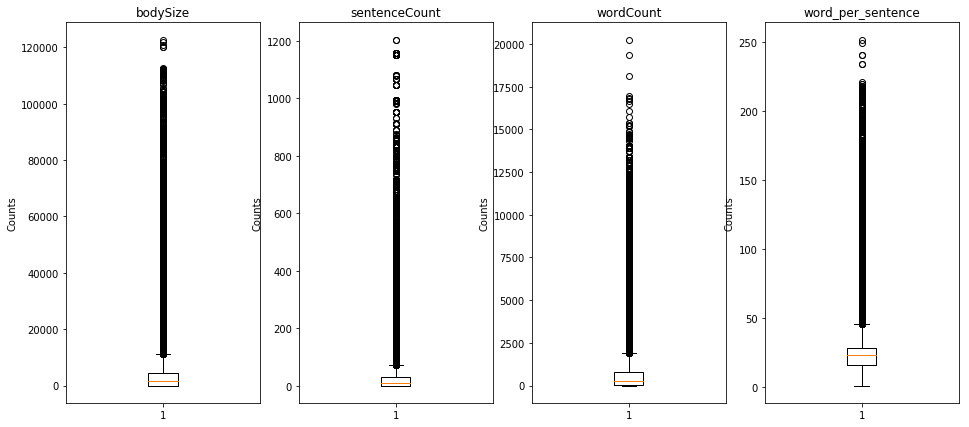

In [32]:
fig, ax = plt.subplots(1,4, figsize=(16,7))
i = 0
for n in ['bodySize', 'sentenceCount', 'wordCount', 'word_per_sentence']:
    ax[i].boxplot(news_train_df[n])
    ax[i].set_title(n)
    ax[i].set_ylabel('Counts')
    i += 1

(array([0.10498829, 0.00521244, 0.00203631, 0.00165101, 0.00515956]),
 array([ 1. ,  9.4, 17.8, 26.2, 34.6, 43. ]),
 <a list of 5 Patch objects>)

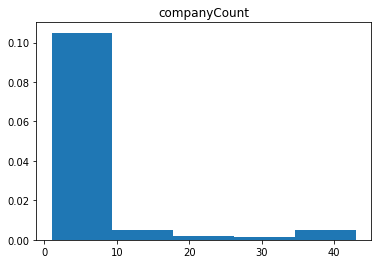

In [33]:
plt.title('companyCount')
plt.hist(news_train_df['companyCount'], bins=5, density=True)

### SentimentClass
marketCommentary(bool) - boolean indicator that the item is discussing general market conditions, such as "After the Bell" summaries.  
  
sentimentClass(int8) - indicates the predominant sentiment class for this news item with respect to the asset. The indicated class is the one with the highest probability.  
sentimentNegative(float32) - probability that the sentiment of the news item was negative for the asset  
sentimentNeutral(float32) - probability that the sentiment of the news item was neutral for the asset  
sentimentPositive(float32) - probability that the sentiment of the news item was positive for the asset  
  
sentimentWordCount(int32) - the number of lexical tokens in the sections of the item text that are deemed relevant to the asset. This can be used in conjunction with wordCount to determine the proportion of the news item discussing the asset.  

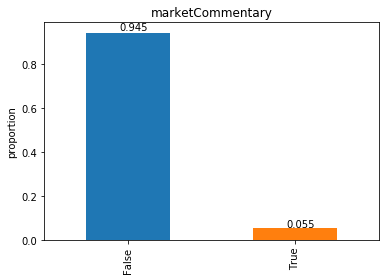

In [34]:
# boolean
plot_class_hist(news_train_df['marketCommentary'].value_counts() / len(news_train_df))

Most(94.5%) of news didn't give market commentary about the company.

In [35]:
news_train_df.loc[:,'sentimentClass':'sentimentPositive'].head()

,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive
0,-1,0.500739,0.419327,0.079934
1,-1,0.600082,0.345853,0.054064
2,-1,0.450049,0.295671,0.254280
3,-1,0.752917,0.162715,0.084368
4,-1,0.699274,0.209360,0.091366


In [36]:
news_sentiment = news_train_df.groupby(
    ["assetName"]).apply(
    lambda x: x['sentimentClass'].value_counts())
# news_sentiment = news_sentiment.set_index(['assetName','level_1'])
news_sentiment = news_sentiment.unstack(level=-1)

In [ ]:
trace0 = go.Bar(
    x=news_sentiment.index[:10],
    y=news_sentiment.iloc[:,0][:10],
    name='sentimentNegative',
)
trace1 = go.Bar(
    x=news_sentiment.index[:10],
    y=news_sentiment.iloc[:,1][:10],
    name='sentimentNeutral',
)
trace2 = go.Bar(
    x=news_sentiment.index[:10],
    y=news_sentiment.iloc[:,2][:10],
    name='sentimentPositive',
)

data = [trace0, trace1, trace2]

py.iplot(dict(data=data))
del news_sentiment

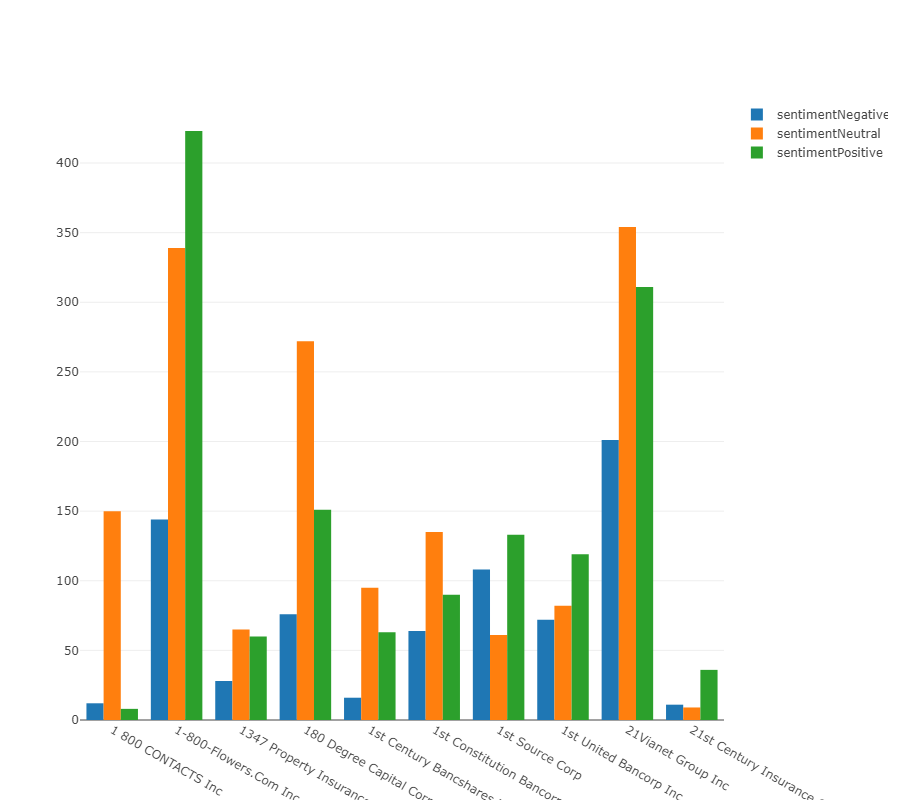

In [3]:
Image(filename = "newplot4.png", width=800, height=800)

In [38]:
for i, j in zip([-1, 0, 1], ['negative', 'neutral', 'positive']):
    df_sentiment = news_train_df.loc[news_train_df['sentimentClass'] == i, 'assetName']
    print('Top mentioned companies for {} sentiment are:'.format(j))
    print(df_sentiment.value_counts().head(5))
    print('')

Top mentioned companies for negative sentiment are:
Citigroup Inc              30823
JPMorgan Chase & Co        29129
Bank of America Corp       28197
Apple Inc                  26702
Goldman Sachs Group Inc    25044
Name: assetName, dtype: int64

Top mentioned companies for neutral sentiment are:
Barclays PLC         24898
HSBC Holdings PLC    23191
Deutsche Bank AG     20702
BHP Billiton PLC     18019
Rio Tinto PLC        16782
Name: assetName, dtype: int64

Top mentioned companies for positive sentiment are:
Barclays PLC             22855
Apple Inc                22770
General Electric Co      20055
Royal Dutch Shell PLC    18206
Citigroup Inc            18025
Name: assetName, dtype: int64



### noveltyCount 
noveltyCount12H(int16) - The 12 hour novelty of the content within a news item on a particular asset. It is calculated by comparing it with the asset-specific text over a cache of previous news items that contain the asset.  
noveltyCount24H(int16) - same as above, but for 24 hours  
noveltyCount3D(int16) - same as above, but for 3 days  
noveltyCount5D(int16) - same as above, but for 5 days  
noveltyCount7D(int16) - same as above, but for 7 days  

In [39]:
news_train_df.loc[:,'noveltyCount12H':'noveltyCount7D'].describe()

,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D
count,9.328750e+06,9.328750e+06,9.328750e+06,9.328750e+06,9.328750e+06
mean,1.385130e+00,1.587036e+00,2.122713e+00,2.574199e+00,3.170360e+00
std,8.220864e+00,8.533866e+00,1.071454e+01,1.295648e+01,1.657174e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
max,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02


### VolumeCounts
volumeCounts12H(int16) - the 12 hour volume of news for each asset. A cache of previous news items is maintained and the number of news items that mention the asset within each of five historical periods is calculated.  
volumeCounts24H(int16) - same as above, but for 24 hours  
volumeCounts3D(int16) - same as above, but for 3 days  
volumeCounts5D(int16) - same as above, but for 5 days  
volumeCounts7D(int16) - same as above, but for 7 days  

In [40]:
news_train_df.loc[:,'volumeCounts12H':'volumeCounts7D'].head()

,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,0,0,3,6,7
1,1,1,3,3,3
2,0,0,5,11,17
3,0,0,5,13,15
4,0,0,0,0,0


In [41]:
news_train_df.loc[:,'volumeCounts12H':'volumeCounts7D'].describe()

,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
count,9.328750e+06,9.328750e+06,9.328750e+06,9.328750e+06,9.328750e+06
mean,8.522672e+00,1.230676e+01,2.206458e+01,3.008566e+01,4.050544e+01
std,2.930322e+01,3.436895e+01,5.431875e+01,6.990158e+01,8.948574e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
50%,4.000000e+00,5.000000e+00,8.000000e+00,1.000000e+01,1.300000e+01
75%,9.000000e+00,1.300000e+01,2.200000e+01,3.000000e+01,4.100000e+01
max,2.564000e+03,2.569000e+03,2.586000e+03,2.599000e+03,2.974000e+03


# Data Preparation
calculate sum or average factor values for stocks by day  
combine market and news dataframes

In [42]:
# prepare news dataframe
news_df = news_train_df.groupby(['assetCodes', 'date_news'], as_index=False).agg({
    'urgency': 'mean',  # (1,2,3) average urgency of all news in that day 
    'bodySize': 'sum',  # total body size for all news in that day for the asset
    'companyCount': 'sum',
    'headlineTag': 'sum',
    'marketCommentary': 'mean',  # (0-1) more market commentary in that day, closer to 1
    'sentenceCount': 'sum',
    'wordCount': 'sum',
    'firstMentionSentence': 'mean',
    'relevance': 'mean',
    'sentimentNegative': 'mean',
    'sentimentNeutral': 'mean',
    'sentimentPositive': 'mean',
    'sentimentWordCount': 'sum',
    'headline_length': 'sum',
    'noveltyCount12H': 'mean',
    'noveltyCount24H': 'mean',
    'noveltyCount3D': 'mean',
    'noveltyCount5D': 'mean',
    'noveltyCount7D': 'mean',
    'volumeCounts12H': 'mean',
    'volumeCounts24H': 'mean',
    'volumeCounts3D': 'mean',
    'volumeCounts5D': 'mean',
    'volumeCounts7D': 'mean'
})

In [43]:
def max_sentiment(x):
    if x['sentimentNegative'] > x['sentimentNeutral'] and x['sentimentNegative'] > x['sentimentPositive']:
        return -1
    if x['sentimentPositive'] > x['sentimentNeutral'] and x['sentimentPositive'] > x['sentimentNegative']:
        return 1
    else:
        return 0

In [44]:
news_df['word_per_sentence'] = news_df['wordCount'] / news_df['sentenceCount']
news_df['sentimentWordProportion'] = news_df[
    'sentimentWordCount'] / news_df['wordCount']
news_df['sentimentClass'] = news_df.apply(max_sentiment, axis=1)

In [45]:
# Combine data frames
df = pd.merge(market_train_df, news_df, how='left', left_on=['date_market', 'assetCode'], 
              right_on=['date_news', 'assetCodes'])
df.dropna(axis=0, inplace=True)
df.drop(['date_news'], axis=1, inplace=True)
df.rename(columns={'date_market': 'date'}, inplace=True)

In [46]:
# binary value for y values
df['label'] = df.returnsOpenNextMktres10.map(lambda x: 0 if x < 0 else 1)

## Handling Numerical and Categorical Variables
one hot encode categorical variable sentimentClass: -1, 0, 1  
normalize numerical variables

In [47]:
encode_col = ['sentimentClass']
scale_col = ['volume', 'returnsClosePrevRaw1',
       'returnsOpenPrevRaw1', 'returnsClosePrevMktres1',
       'returnsOpenPrevMktres1', 'returnsClosePrevRaw10',
       'returnsOpenPrevRaw10', 'returnsClosePrevMktres10',
       'returnsOpenPrevMktres10', 'marketCommentary', 'relevance',
       'macd', 'rsi', 'mom', 'obv', 'close_std10',
       'volume_sum10', 'urgency', 'bodySize', 'companyCount',
       'headlineTag', 'sentenceCount', 'wordCount',
       'firstMentionSentence', 'sentimentWordCount',
       'headline_length', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D',
       'word_per_sentence', 'sentimentWordProportion']
y_col = ['returnsOpenNextMktres10']

In [48]:
def encode_categorical(df, cat_cols):
    print('encoding categorical columns... Done')
    
    cat_encoded_df = pd.get_dummies(df[cat_cols[0]], prefix=cat_cols[0])
    return cat_encoded_df

In [49]:
from sklearn.preprocessing import StandardScaler

def scale_numerical(df, num_cols):
    print('scaling numerical columns... Done')

    scaler = StandardScaler()  # with mean 0 and variance 1
    df[num_cols] = scaler.fit_transform(df[num_cols])

In [50]:
cat_encoded_df = encode_categorical(df, encode_col)
cat_col = cat_encoded_df.columns
df = pd.concat([df, cat_encoded_df], axis=1)
scale_numerical(df, scale_col)

encoding categorical columns... Done
scaling numerical columns... Done


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

Data with input dtype float32, float64 were all converted to float64 by StandardScaler.

/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning:

Data with input dtype float32, float64 were all converted to float64 by StandardScaler.



In [51]:
cat_col = list(cat_col)
X_col = cat_col + scale_col

## Split Train, Valid, Test datasets
Train & validation set: February 2007 to December 2015  
Test set for trading: Jan 2016 to December 2016 (1 year)

In [52]:
split_date = '2015-12-31 22:00:00+0000'
train_set = df.loc[df['time'] <= split_date]
test_set = df.loc[df['time'] > split_date]
print('Splitting into training and testing ...Done')

Splitting into training and testing ...Done


In [53]:
sp500 = sp500.loc[split_date:,:]
sp500['return'] = sp500['S&P 500'].pct_change()

In [54]:
split_date = '2015-03-02 22:00:00+0000'
train_nn = train_set.loc[train_set.time < split_date, :]
val_nn = train_set.loc[train_set.time >= split_date, :]
print('Splitting into training and validation ...Done')

Splitting into training and validation ...Done


# LSTM Network Modeling
## LSTM
Long short-term memory (LSTM) units are units of a recurrent neural network (RNN). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.
  
LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the exploding and vanishing gradient problems that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications
  
## Setting up Model
  
### Input
(time window, feature) = (10, 41) for each stock for each day
  
### Output
probability of positive 10-day residual return for each stock for each day
  
### Speed up process
1. Normalize input (X)  
2. Initialize weight, uses activation 'relu'  
3. Using mini-batch gradient descent: 32, 64, 128...  
4. Using 'adam' optimizer  
5. Using batch normalization before activation
6. Uses early stopping
  
### Hyperparameters
* batch size: 32(default), 64(compare)    
* hidden units/layers: > 3 layers, [64, 16, 1] (default) seems reasonable with a starting 41 features, [128, 64, 16, 1] for comparison  
* time window size: only use 10(default) because of memory issue  
* epoch:  5 and early stop if not improving after 2 epoches, I tried 10 epoches and don't see improvements after first two epoches most of time
* loss: binary crossentropy, to classify positive or negative 10-day residual returns
  
Source: https://medium.com/machine-learning-bites/deeplearning-series-deep-neural-networks-tuning-and-optimization-39250ff7786d

In [55]:
def load_data(data, window, data_name):
    print('Loading {} data for model, window length: {}'.format(data_name, window))
    
    X, y, d, r, u = [], [], [], [], []
    index_record = np.array([])
    groupby_obj = data.groupby(['assetCode'], sort=False)

    for _, data in groupby_obj:

        data = data.sort_values(by=['date'])
        num_sequences = data.shape[0] - window 
        
        if num_sequences > 0:
            for seq in range(num_sequences):
                index_record = np.append(index_record, data.index.values[seq+window-1])
                # window days of X to predict one y
                X.append(data[X_col].iloc[seq:seq+window].values)  # X: 2d arrays
                y.append(data.label.iloc[seq+window-1])  # y binary: one point
                d.append(data.date.iloc[seq+window-1])  # date
                r.append(data.returnsOpenNextMktres10.iloc[seq+window-1])  # returns
                u.append(data.universe.iloc[seq+window-1])  # universe
    
    # 1 feature
    X, y, d, r, u = np.array(X), np.array(y), np.array(d), np.array(r), np.array(u)
    
    print('                            ...Done')
    return X, y, d, r, u, index_record

In [56]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, LSTM, Activation
from keras.losses import binary_crossentropy

def build_model(layers, X_train):
    model = Sequential()
    
    # first layer
    model.add(BatchNormalization())
    model.add(LSTM(
        input_shape=(X_train.shape[1], X_train.shape[2]),  # first layer need input shape, window length 10
        output_dim=layers[0],
        activation='relu',
        return_sequences=True))  # must return TRUE for input of next layer of LSTM
    
    for i in range(1, len(layers)-2):
        model.add(LSTM(
            output_dim = layers[i],  # output dimension
            activation='relu',
            return_sequences=True))  # must return TRUE for input of next layer of LSTM

    # second last layer
    model.add(LSTM(
        output_dim = layers[-2],  # output dimension
        activation='relu',
        return_sequences=False))

    # last layer
    model.add(Dense(
        output_dim=layers[-1], 
        activation="sigmoid"))

    start = time.time()
    model.compile(optimizer='adam',loss=binary_crossentropy, metrics=['accuracy'])
    print("Model Compilation Time : ", time.time() - start)
    return model

Using TensorFlow backend.


In [57]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
X_train, y_train, X_test, y_test = None, None, None, None
data_loaded = False

def run_model(layers=[64, 16, 1], epoch=5, batch=64, window=10):
    global X_train, y_train, X_test, y_test, data_loaded
    
    start = datetime.now()
    if len(layers) < 3:
        print('>>> ERROR: at least 3 layers!!! Your layers: {}'.format(layers))
        return
    
    print('>>> START RUNNING ...')
    print('>>> Building model, layers: {}'.format(layers))
    if not data_loaded:
        data_loaded = True
        X_train, y_train, _, _, _, _ = load_data(train_nn, window, 'train')
        X_test, y_test, _, _, _, _ = load_data(val_nn, window, 'validation')
    lstm_model = build_model(layers, X_train)
    
    # fit on difference hyperparameter values
    print('>>> Fitting model, epoch: {}, batch size: {}'.format(epoch, batch))
    check_point = ModelCheckpoint('model.hdf5',verbose=True, save_best_only=True)
    early_stop = EarlyStopping(patience=2,verbose=True)
    lstm_model.fit(
        X_train, 
        y_train, 
        epochs=epoch,
        batch_size=batch,
        validation_data=(X_test, y_test), 
        callbacks=[early_stop, check_point])
    
    # model prediction
    print('>>> Doing prediction ...')
    X_pred, y_pred, d_pred, r_pred, u_pred, index_pred = load_data(test_set, window, 'test')
    lstm_model.load_weights('model.hdf5')
    # store result: assetCode, date, 
    pred_result = test_set.loc[index_pred, ['assetCode', 'date']]
    # > 0.5, predicted positive return, < 0.5, predicted negative return
    pred_result['pred_r'] = np.array([lstm_model.predict(
        X.reshape(1,X_pred.shape[1],X_pred.shape[2]))[0][0] for X in X_pred])
    pred_result['pred_y'] = (pred_result['pred_r'] * 2 - 1 > 0).astype(int)
    pred_result['actual_r'] = r_pred
    pred_result['actual_y'] = y_pred
    # whether the stock is tradable on that day
    pred_result['universe'] = u_pred
    
    print(lstm_model.summary())
    
    print(">>> Model Running Time : ", datetime.now() - start)
    print('************************ Finished!!! ************************')
    return pred_result

In [58]:
result1 = run_model()
result2 = run_model(layers=[64, 16, 1], epoch=5, batch=128)
result3 = run_model(layers=[128, 64, 16, 1], epoch=5, batch=64)

>>> START RUNNING ...
>>> Building model, layers: [64, 16, 1]
Loading train data for model, window length: 10
                            ...Done
Loading validation data for model, window length: 10
                            ...Done
Model Compilation Time :  0.017302274703979492
>>> Fitting model, epoch: 5, batch size: 64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 41), activation="relu", return_sequences=True, units=64)`

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(activation="relu", return_sequences=False, units=16)`

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning:

Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`



Train on 621221 samples, validate on 63043 samples
Epoch 1/5
621221/621221 [==============================] - 152s 244us/step - loss: 0.6852 - acc: 0.5518 - val_loss: 0.6925 - val_acc: 0.5345

Epoch 00001: val_loss improved from inf to 0.69248, saving model to model.hdf5
Epoch 2/5
621221/621221 [==============================] - 150s 241us/step - loss: 0.6815 - acc: 0.5608 - val_loss: 0.7003 - val_acc: 0.5281

Epoch 00002: val_loss did not improve from 0.69248
Epoch 3/5
621221/621221 [==============================] - 155s 250us/step - loss: 0.6788 - acc: 0.5659 - val_loss: 0.7156 - val_acc: 0.5151

Epoch 00003: val_loss did not improve from 0.69248
Epoch 00003: early stopping
>>> Doing prediction ...
Loading test data for model, window length: 10
                            ...Done
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 10, 41)            164       
________

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(10, 41), activation="relu", return_sequences=True, units=128)`

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(activation="relu", return_sequences=True, units=64)`



Train on 621221 samples, validate on 63043 samples
Epoch 1/5
621221/621221 [==============================] - 275s 443us/step - loss: 0.6856 - acc: 0.5513 - val_loss: 0.6963 - val_acc: 0.5204

Epoch 00001: val_loss improved from inf to 0.69634, saving model to model.hdf5
Epoch 2/5
621221/621221 [==============================] - 284s 457us/step - loss: 0.6816 - acc: 0.5597 - val_loss: 0.6982 - val_acc: 0.5198

Epoch 00002: val_loss did not improve from 0.69634
Epoch 3/5
621221/621221 [==============================] - 285s 459us/step - loss: 0.6778 - acc: 0.5689 - val_loss: 0.7139 - val_acc: 0.5063

Epoch 00003: val_loss did not improve from 0.69634
Epoch 00003: early stopping
>>> Doing prediction ...
Loading test data for model, window length: 10
                            ...Done
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 10, 41)            164       
________

In [59]:
result1.to_csv('../input/result1.csv')
result2.to_csv('../input/result2.csv')
result3.to_csv('../input/result3.csv')

# Performance Analysis
Construct portfolio that long stocks with positive predicted return and short stocks with negative predicted return with initial capital 10,000,000 in total. Then, portfolio is compared with SP500 index performance.

In [60]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score

def performance_result(result, capital = 10000000., rebalance=1):
    
    'define function to calculate maximum drawdown'
    def MaxDrawdown(Ret_Cum):
        # ret_cum also can be portfolio position series
        ContVal = np.zeros(np.size(Ret_Cum))
        MaxDD = np.zeros(np.size(Ret_Cum))
        for i in range(np.size(Ret_Cum)):
            if i == 0:
                if Ret_Cum[i] < 0:
                    ContVal[i] = Ret_Cum[i]
                else:
                    ContVal[i] = 0
            else:
                ContVal[i] = Ret_Cum[i] - np.max(Ret_Cum[0:(i+1)])
            MaxDD[i] = np.min(ContVal[0:(i+1)])
        return MaxDD
    
    ' confusion matrix '
    def plot_confusion(conmat):
        confusion = pd.DataFrame(conmat, index=['negative', 'positive'], 
                                 columns=['predicted negative', 'predicted positive'])
        print(confusion)
    print('>>> Confusion Matrix')
    result_conf = confusion_matrix(result['actual_y'], result['pred_y'])
    plot_confusion(result_conf)
    
    # classification report
    print('\n>>> Classfication Report')
    print(classification_report(result['pred_y'], result['actual_y']))
    
    # manipulate data
    result_df = result[result['universe'] == 1]
    result_df_pred = result_df[['assetCode', 'date', 'pred_y']]
    result_df_pred.set_index(['assetCode', 'date'], inplace=True)
    result_df_pred = result_df_pred.unstack(level=0)
    result_df_pred.columns = result_df_pred.columns.get_level_values(1)
    result_df_ret = result_df[['assetCode', 'date', 'actual_r']]
    result_df_ret.set_index(['assetCode', 'date'], inplace=True)
    result_df_ret = result_df_ret.unstack(level=0)
    result_df_ret.columns = result_df_ret.columns.get_level_values(1)

    # resample data by business day
    if len(result_df_pred) > rebalance > 1:
        result_df_pred = result_df_pred.resample(str(rebalance)+'B', 
                                                 convention='start').asfreq()
        result_df_ret = result_df_ret.resample(str(rebalance)+'B', 
                                                 convention='start').sum()

    # get long short portfolio
    result_df_pred_short = 1 - result_df_pred
    long = result_df_pred.sum(axis=1) / (result_df_pred.sum(axis=1) 
                                         + result_df_pred_short.sum(axis=1))
    long_df = result_df_pred * result_df_ret.values  # df
    short = 1 - long
    short_df = result_df_pred_short * result_df_ret.values

    # get portfolio cumpnl & maximum drawdown
    port_ret = long * long_df.mean(axis=1) + short * short_df.mean(axis=1)
    port_cumpnl = capital * (1+port_ret.cumsum())
    maxDD = MaxDrawdown(port_cumpnl.values) + capital

    # sp500 returns & cumpnl
    sp500_ret = sp500.loc[port_ret.index, :]
    sp500_cumret = sp500_ret['return'].cumsum()
    sp500_cumpnl = capital * (1 + sp500_cumret)

    plt.figure(figsize=(12,7))
    plt.title("Market Neutral Portfolio Performance using LSTM")
    plt.xlabel("Date")
    plt.ylabel("Cumulative PnL")
    plt.plot(port_cumpnl, label="Portfolio P/L")
    plt.plot(pd.Series(maxDD, index=port_ret.index), label="Portfolio Maximum Drawdown")
    plt.plot(sp500_cumpnl, label = "SP500 P/L")
    plt.legend()

    sp500_mean = round(sp500_ret['return'].mean(), 4)
    sp500_std = round(sp500_ret['return'].std(), 4)
    sharpe = round(sp500_mean / sp500_std, 3)
    print('>>> For SP500:')
    print('Mean daily return: {}, Total return: {}, Daily return volatility {}, Sharpe ratio: {}'.format(
            sp500_mean, round(sp500_cumret[-1], 3), sp500_std*100, sharpe))

    port_mean = round(port_ret.mean(), 4)
    port_std = round(port_ret.std(), 4)
    sharpe = round(port_mean / port_std, 3)
    print('\n>>> For my portfolio:')
    print('Mean daily return: {}, Total return: {}, Daily return volatility {}, Sharpe ratio: {}, Maximum Drawdown: ${}'.format(
            port_mean, round(port_ret.cumsum()[-1], 3), 
            port_std, sharpe, maxDD[-1]))
    

>>> Confusion Matrix
          predicted negative  predicted positive
negative               11312               23805
positive                9484               27935

>>> Classfication Report
              precision    recall  f1-score   support

           0       0.32      0.54      0.40     20796
           1       0.75      0.54      0.63     51740

   micro avg       0.54      0.54      0.54     72536
   macro avg       0.53      0.54      0.52     72536
weighted avg       0.62      0.54      0.56     72536

>>> For SP500:
Mean daily return: 0.0007, Total return: 0.165, Daily return volatility 0.79, Sharpe ratio: 0.089

>>> For my portfolio:
Mean daily return: 0.0017, Total return: 0.402, Daily return volatility 0.0064, Sharpe ratio: 0.266, Maximum Drawdown: $8606021.415805038


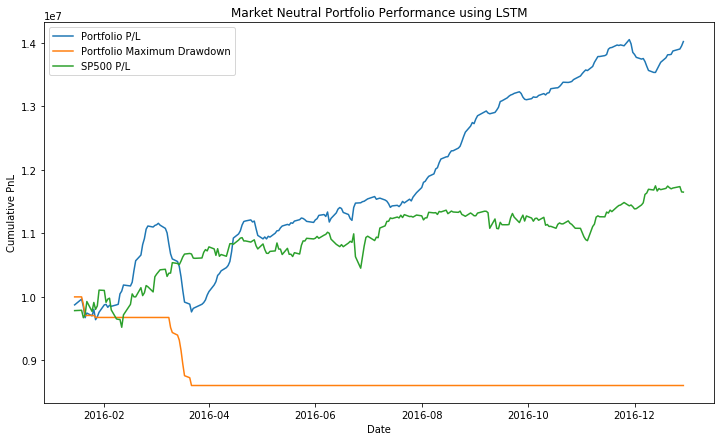

In [61]:
performance_result(result1)

>>> Confusion Matrix
          predicted negative  predicted positive
negative               13878               21239
positive               12128               25291

>>> Classfication Report
              precision    recall  f1-score   support

           0       0.40      0.53      0.45     26006
           1       0.68      0.54      0.60     46530

   micro avg       0.54      0.54      0.54     72536
   macro avg       0.54      0.54      0.53     72536
weighted avg       0.58      0.54      0.55     72536

>>> For SP500:
Mean daily return: 0.0007, Total return: 0.165, Daily return volatility 0.79, Sharpe ratio: 0.089

>>> For my portfolio:
Mean daily return: 0.0013, Total return: 0.326, Daily return volatility 0.0059, Sharpe ratio: 0.22, Maximum Drawdown: $8709222.256880438


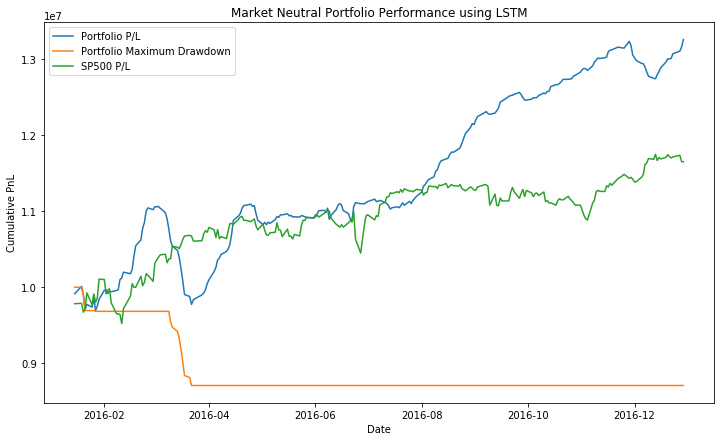

In [62]:
performance_result(result2)

>>> Confusion Matrix
          predicted negative  predicted positive
negative                9496               25621
positive                7817               29602

>>> Classfication Report
              precision    recall  f1-score   support

           0       0.27      0.55      0.36     17313
           1       0.79      0.54      0.64     55223

   micro avg       0.54      0.54      0.54     72536
   macro avg       0.53      0.54      0.50     72536
weighted avg       0.67      0.54      0.57     72536

>>> For SP500:
Mean daily return: 0.0007, Total return: 0.165, Daily return volatility 0.79, Sharpe ratio: 0.089

>>> For my portfolio:
Mean daily return: 0.002, Total return: 0.472, Daily return volatility 0.0065, Sharpe ratio: 0.308, Maximum Drawdown: $8731969.471954437


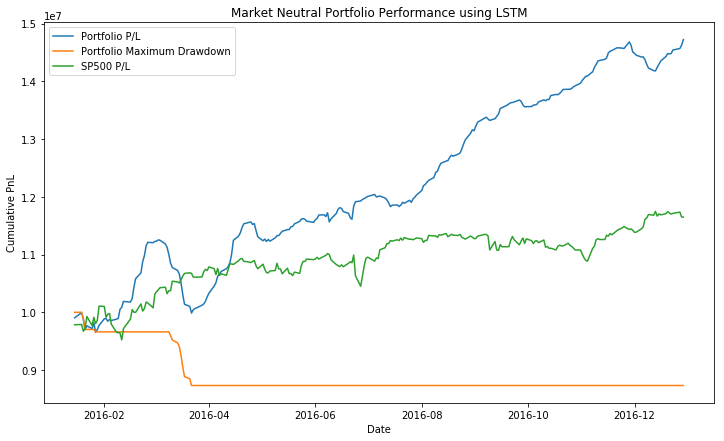

In [63]:
performance_result(result3)

# Conclusion
We can see from 3 results with different parameters all using LSTM model that they all perform significantly better than SP500. The best LSTM model with 4 layers produces 0.3 Sharpe ratio and 40% total return over the year 2016. I would say news combined with technical indicators effectively predicts stock returns and earn a good return.    
  
By comparison of models using different parameters, we can see from the results that adding one more layer improves the result a little bit as precision, recall, f1-score, Sharpe ratio all increase. However, if we incerase batch size, the result actually become worse.  
  
For further improvement, I should do a deeper analysis of each news factor and their interactions. Since there are memory and runtime constraint for this project, if those are not issues, I should try LSTM models with different set of hyperparameters and compare. Possibly, I should also try model other than LSTM, such as gradient boosting which is also good for binary classifier. Since for my portfolio, it is rebalanced daily and transaction cost will be a big factor affecting profit, and I didn't subtract transaction cost, I would like to add transaction cost into my calculation for further improvement.